In [1]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import lmfit
import math

import function as func
import csv

In [5]:
# 2023.06.26
datalist1 = \
[
{'path':'/data/analysis/adachi/data/20230721_DOSUE-J_VNA/20230721_reflection_no_isolator.csv', 'csvType':'VNA', 'channel':0, 'label':'No Isolator'},
{'path':'/data/analysis/adachi/data/20230721_DOSUE-J_VNA/20230721_reflection_wt_isolator.csv', 'csvType':'VNA', 'channel':0, 'label':'With Isolator'},
]

datalist = datalist1

In [6]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='VNA', start_freq=None, stop_freq=None, npoints=None, channel=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
    elif csvType=='VNA' : # VNA
        
        columns = None
        _freq_list = []
        _power_list = []
        _freq = []
        _power = []
        for line in fin:
            if len(line)==0 : continue
            first = line[0].split()[0].strip()
            # Search for data starting point (VNA: BEGIN)
            #print(f'first = {first}')
            if first == 'BEGIN':
                isData = True
                _freq = []
                _power = []
                continue
            elif first == 'END':
                isData = False
                _freq_list.append( _freq )
                _power_list.append( _power )
                columns = None
                pass
            # Get data
            if isData:
                if columns is None:
                    columns = line
                    continue
                _freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                _power.append(10 ** (float(line[1])*0.1)) # dB --> ratio
                pass
            pass
        
        freq = _freq_list[channel]
        power = _power_list[channel]
 
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)

In [8]:
for n, _d in enumerate(datalist):
    _freq, _power = read_csv(_d['path'], _d['csvType'], channel=_d['channel'])
    datalist[n]['freq'] = _freq
    datalist[n]['power'] = _power
    pass

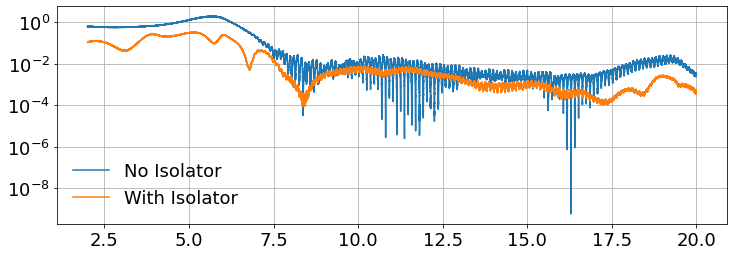

In [10]:
fig = plt.figure(figsize = (12, 4))
for n, _d in enumerate(datalist):
    plt.plot(_d['freq'], _d['power'], label=_d['label'])
    pass
plt.yscale('log')
plt.grid(True)
plt.legend(frameon=False)

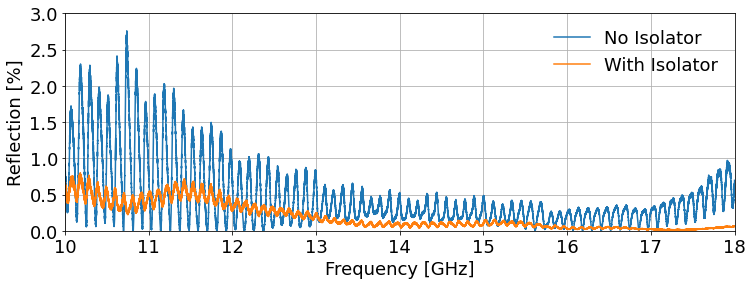

In [19]:
fig = plt.figure(figsize = (12, 4))
for n, _d in enumerate(datalist):
    plt.plot(_d['freq'], _d['power']*100, label=_d['label'])
    pass
plt.yscale('linear')
plt.xlim(10, 18)
plt.ylim(0, 3)
plt.ylabel('Reflection [%]')
plt.xlabel('Frequency [GHz]')
plt.grid(True)
plt.legend(frameon=False)

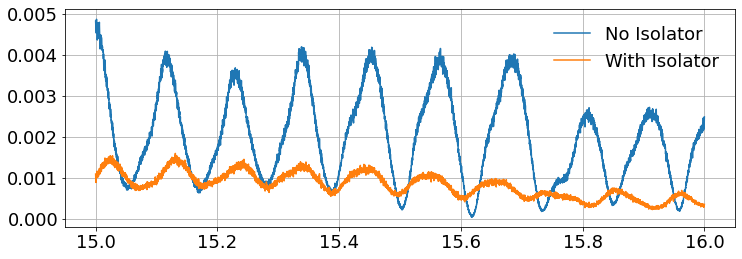

In [11]:
fig = plt.figure(figsize = (12, 4))
_xlim = [15,16]
for n, _d in enumerate(datalist):
    _freq = _d['freq']
    _pass = np.where( (_freq>=_xlim[0]) & (_freq<=_xlim[1]) )
    _freq = _freq[_pass]
    _power = _d['power'][_pass]
    plt.plot(_freq, _power, label=_d['label'])
    pass
#plt.yscale('log')
#plt.ylim([1e-3, 1])
plt.yscale('linear')
#plt.ylim([0, 1])
plt.grid(True)
plt.legend(frameon=False)

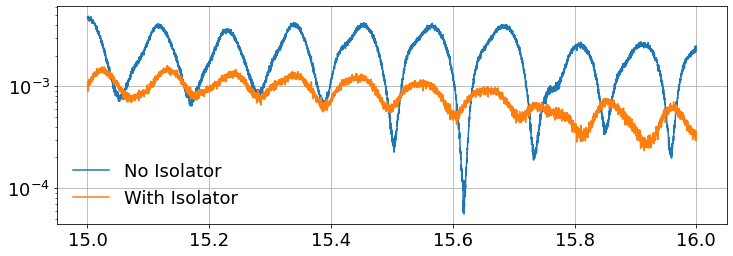

In [12]:
fig = plt.figure(figsize = (12, 4))
_xlim = [15,16]
for n, _d in enumerate(datalist):
    _freq = _d['freq']
    _pass = np.where( (_freq>=_xlim[0]) & (_freq<=_xlim[1]) )
    _freq = _freq[_pass]
    _power = _d['power'][_pass]
    plt.plot(_freq, _power, label=_d['label'])
    pass
#plt.xlim([15.6,15.8])
plt.yscale('log')
#plt.ylim([1e-6, 1.])
#plt.ylim([0, 0.01])
plt.grid(True)
plt.legend(frameon=False)